# Importing Packages

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import yahoo_fin.stock_info as si

from sklearn.model_selection import train_test_split

import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error  
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping 
from sklearn.preprocessing import RobustScaler 
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# Downloading Stock Price Data

In [3]:
# from stockprice.py
def create_data(ticker, start = "2021-01-04", end = "2023-11-14"):
    company = si.get_data(ticker)
    company = company.loc[start:end] # 01-04 is the first Monday of 2021.
    company["date"] = company.index
    company = company.reset_index()
    company.drop(columns = "index", inplace = True)
    return company

In [101]:
df = create_data("SBUX")
df

,open,high,low,close,adjclose,volume,ticker,date
0,107.660004,107.750000,102.139999,103.099998,97.033081,8041500,SBUX,2021-01-04
1,102.919998,104.260002,102.800003,103.440002,97.353065,5721900,SBUX,2021-01-05
2,102.989998,105.209999,102.910004,104.190002,98.058945,5017200,SBUX,2021-01-06
3,104.489998,104.639999,102.949997,103.349998,97.268364,5057000,SBUX,2021-01-07
4,103.860001,105.760002,103.419998,105.669998,99.451836,5869700,SBUX,2021-01-08
...,...,...,...,...,...,...,...,...
717,103.739998,104.820000,103.650002,104.300003,103.730003,7453000,SBUX,2023-11-08
718,104.300003,104.459999,102.029999,102.230003,102.230003,7607000,SBUX,2023-11-09
719,102.599998,104.349998,101.980003,104.330002,104.330002,7338500,SBUX,2023-11-10
720,103.919998,104.230003,102.959999,103.510002,103.510002,7120800,SBUX,2023-11-13


In [102]:
sentiment = pd.read_csv("final_score.csv")
sentiment.shape

(722, 2)

In [103]:
df2 = df.copy()
sentiment_col = sentiment["Score"]
df2["sentiment"] = sentiment_col.tolist()
df2

,open,high,low,close,adjclose,volume,ticker,date,sentiment
0,107.660004,107.750000,102.139999,103.099998,97.033081,8041500,SBUX,2021-01-04,2.000000
1,102.919998,104.260002,102.800003,103.440002,97.353065,5721900,SBUX,2021-01-05,1.250000
2,102.989998,105.209999,102.910004,104.190002,98.058945,5017200,SBUX,2021-01-06,0.625000
3,104.489998,104.639999,102.949997,103.349998,97.268364,5057000,SBUX,2021-01-07,0.000000
4,103.860001,105.760002,103.419998,105.669998,99.451836,5869700,SBUX,2021-01-08,1.300000
...,...,...,...,...,...,...,...,...,...
717,103.739998,104.820000,103.650002,104.300003,103.730003,7453000,SBUX,2023-11-08,1.894737
718,104.300003,104.459999,102.029999,102.230003,102.230003,7607000,SBUX,2023-11-09,1.812500
719,102.599998,104.349998,101.980003,104.330002,104.330002,7338500,SBUX,2023-11-10,1.615385
720,103.919998,104.230003,102.959999,103.510002,103.510002,7120800,SBUX,2023-11-13,1.344444


# Cleaning Data

In [32]:
def clean_data(data):
    return data.dropna(ignore_index = True)

# Adding Features

In [87]:
def add_features(data):
    
    # add column for quarterly months: 3,6,9,12
    split_date = data["date"].astype(str).str.split("-", expand = True) # year, month, day
    data["month"] = split_date[1].astype("int")
    data["day"] = split_date[2].astype("int")
    data["year"] = split_date[0].astype("int")
    data['date'] = pd.to_datetime(data["date"])
    data["quarterly_reports"] = data['date'].dt.month.isin([1, 4, 7, 10]).astype(int)
    
    # add open-close and low-high columns
    data["open-close"] = data["open"] - data["close"]
    data["low-high"] = data["low"] - data["high"]
    
    # add Estimated Moving Average using time window of 100 days
    data['EMA100'] = data['close'].ewm(span=100, adjust=False).mean()
    
    # add Bollinger Bands
    data['MA20'] = data['close'].rolling(window=20).mean() # moving average for 20 day period
    data['MA20dSTD'] = data['close'].rolling(window=20).std() # moving average standard deviation for 20 day period
    data['Bollinger_Upper'] = data['MA20'] + (data['MA20dSTD'] * 2)
    data['Bollinger_Lower'] = data['MA20'] - (data['MA20dSTD'] * 2)
    
    # set date as index
    data.set_index('date', inplace=True)
    
    # replace Nans
    na_replace = data.at[data.index.max(), 'close']    
    data.fillna((na_replace), inplace=True)
    
    return data

In [104]:
df = clean_data(df)
df = add_features(df)
df

,open,high,low,close,adjclose,volume,ticker,month,day,year,quarterly_reports,open-close,low-high,EMA100,MA20,MA20dSTD,Bollinger_Upper,Bollinger_Lower
date,,,,,,,,,,,,,,,,,,
2021-01-04,107.660004,107.750000,102.139999,103.099998,97.033081,8041500,SBUX,1,4,2021,1,4.560005,-5.610001,103.099998,105.599998,105.599998,105.599998,105.599998
2021-01-05,102.919998,104.260002,102.800003,103.440002,97.353065,5721900,SBUX,1,5,2021,1,-0.520004,-1.459999,103.106731,105.599998,105.599998,105.599998,105.599998
2021-01-06,102.989998,105.209999,102.910004,104.190002,98.058945,5017200,SBUX,1,6,2021,1,-1.200005,-2.299995,103.128182,105.599998,105.599998,105.599998,105.599998
2021-01-07,104.489998,104.639999,102.949997,103.349998,97.268364,5057000,SBUX,1,7,2021,1,1.139999,-1.690002,103.132575,105.599998,105.599998,105.599998,105.599998
2021-01-08,103.860001,105.760002,103.419998,105.669998,99.451836,5869700,SBUX,1,8,2021,1,-1.809998,-2.340004,103.182821,105.599998,105.599998,105.599998,105.599998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-08,103.739998,104.820000,103.650002,104.300003,103.730003,7453000,SBUX,11,8,2023,0,-0.560005,-1.169998,97.035380,95.600500,4.533484,104.667467,86.533533
2023-11-09,104.300003,104.459999,102.029999,102.230003,102.230003,7607000,SBUX,11,9,2023,0,2.070000,-2.430000,97.138244,96.141000,4.651700,105.444400,86.837601
2023-11-10,102.599998,104.349998,101.980003,104.330002,104.330002,7338500,SBUX,11,10,2023,0,-1.730003,-2.369995,97.280655,96.783500,4.856936,106.497371,87.069629


In [105]:
df2 = clean_data(df2)
df2 = add_features(df2)
df2

,open,high,low,close,adjclose,volume,ticker,sentiment,month,day,year,quarterly_reports,open-close,low-high,EMA100,MA20,MA20dSTD,Bollinger_Upper,Bollinger_Lower
date,,,,,,,,,,,,,,,,,,,
2021-01-04,107.660004,107.750000,102.139999,103.099998,97.033081,8041500,SBUX,2.000000,1,4,2021,1,4.560005,-5.610001,103.099998,105.599998,105.599998,105.599998,105.599998
2021-01-05,102.919998,104.260002,102.800003,103.440002,97.353065,5721900,SBUX,1.250000,1,5,2021,1,-0.520004,-1.459999,103.106731,105.599998,105.599998,105.599998,105.599998
2021-01-06,102.989998,105.209999,102.910004,104.190002,98.058945,5017200,SBUX,0.625000,1,6,2021,1,-1.200005,-2.299995,103.128182,105.599998,105.599998,105.599998,105.599998
2021-01-07,104.489998,104.639999,102.949997,103.349998,97.268364,5057000,SBUX,0.000000,1,7,2021,1,1.139999,-1.690002,103.132575,105.599998,105.599998,105.599998,105.599998
2021-01-08,103.860001,105.760002,103.419998,105.669998,99.451836,5869700,SBUX,1.300000,1,8,2021,1,-1.809998,-2.340004,103.182821,105.599998,105.599998,105.599998,105.599998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-08,103.739998,104.820000,103.650002,104.300003,103.730003,7453000,SBUX,1.894737,11,8,2023,0,-0.560005,-1.169998,97.035380,95.600500,4.533484,104.667467,86.533533
2023-11-09,104.300003,104.459999,102.029999,102.230003,102.230003,7607000,SBUX,1.812500,11,9,2023,0,2.070000,-2.430000,97.138244,96.141000,4.651700,105.444400,86.837601
2023-11-10,102.599998,104.349998,101.980003,104.330002,104.330002,7338500,SBUX,1.615385,11,10,2023,0,-1.730003,-2.369995,97.280655,96.783500,4.856936,106.497371,87.069629


# Splitting and Normalizing Data

In [17]:
def pred_target(features, dataset):
    return dataset[features], dataset["close"] # returns predictor, and target datasets

## Normalizing Data

In [20]:
# should we create this function
def scalers(pred, target):
    # normalize between 0 and 1
    # define scalers
    scaler_pred = MinMaxScaler() # for scaling multiple columns
    scaler_target = MinMaxScaler() # for scaling one column
    # scale data
    scaled_pred = scaler_pred.fit_transform(pred.values)
    scaled_target = scaler_target.fit_transform(target.values.reshape(-1,1))
    return scaler_pred, scaler_target, scaled_pred, scaled_target

In [106]:
# keep features columns
features = ["close", "open", "Bollinger_Upper", "Bollinger_Lower", "EMA100"]
df_feat_pred, df_close_target = pred_target(features, df) # predictor and target data
df_feat_pred.head(), df_close_target.head()

(                 close        open  Bollinger_Upper  Bollinger_Lower  \
 date                                                                   
 2021-01-04  103.099998  107.660004       105.599998       105.599998   
 2021-01-05  103.440002  102.919998       105.599998       105.599998   
 2021-01-06  104.190002  102.989998       105.599998       105.599998   
 2021-01-07  103.349998  104.489998       105.599998       105.599998   
 2021-01-08  105.669998  103.860001       105.599998       105.599998   
 
                 EMA100  
 date                    
 2021-01-04  103.099998  
 2021-01-05  103.106731  
 2021-01-06  103.128182  
 2021-01-07  103.132575  
 2021-01-08  103.182821  ,
 date
 2021-01-04    103.099998
 2021-01-05    103.440002
 2021-01-06    104.190002
 2021-01-07    103.349998
 2021-01-08    105.669998
 Name: close, dtype: float64)

In [127]:
# keep features columns
features2 = ["close", "open", "EMA100", "sentiment", "quarterly_reports"]
df_feat_pred2, df_close_target2 = pred_target(features2, df2) # predictor and target data
df_feat_pred2.head(), df_close_target2.head()

(                 close        open      EMA100  sentiment  quarterly_reports
 date                                                                        
 2021-01-04  103.099998  107.660004  103.099998      2.000                  1
 2021-01-05  103.440002  102.919998  103.106731      1.250                  1
 2021-01-06  104.190002  102.989998  103.128182      0.625                  1
 2021-01-07  103.349998  104.489998  103.132575      0.000                  1
 2021-01-08  105.669998  103.860001  103.182821      1.300                  1,
 date
 2021-01-04    103.099998
 2021-01-05    103.440002
 2021-01-06    104.190002
 2021-01-07    103.349998
 2021-01-08    105.669998
 Name: close, dtype: float64)

In [108]:
scaler_pred, scaler_target, scaled_pred, scaled_target = scalers(df_feat_pred, df_close_target)

In [128]:
scaler_pred2, scaler_target2, scaled_pred2, scaled_target2 = scalers(df_feat_pred2, df_close_target2)

In [110]:
scaled_pred.shape, scaled_target.shape

((722, 5), (722, 1))

In [129]:
scaled_pred2.shape, scaled_target2.shape

((722, 5), (722, 1))

## Splitting Data

In [100]:
def train_val_test(pred, seq_len, scaled_p):
    
    # split data into training, validation, and testing data
    train_len = int(0.7*len(pred))
    val_len = int(0.2*train_len) # validations set is 20% of training set
    
    val_data = scaled_p[:val_len,:]
    train_data = scaled_p[val_len:train_len, :]
    test_data = scaled_p[train_len - seq_len:, :]
    
    return train_data, val_data, test_data

In [25]:
def split_data(seq_len, data, index_close):
    x, y = [], []
    data_len = data.shape[0]

    for i in range(seq_len, data_len):
        x.append(data[i-seq_len:i,:]) # previous 50 day values
        y.append(data[i, index_close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

In [112]:
seq_len = 50
index_close = df_feat_pred.columns.get_loc("close")
train_data, val_data, test_data = train_val_test(df_feat_pred, 50, scaled_p = scaled_pred)
x_train, y_train = split_data(seq_len, train_data, index_close)
x_val, y_val = split_data(seq_len, val_data, index_close)
x_test, y_test = split_data(seq_len, test_data, index_close)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(True if x_train[1][seq_len-1][0] == y_train[0] else False)

(354, 50, 5) (354,)
(51, 50, 5) (51,)
(217, 50, 5) (217,)
True


In [130]:
seq_len = 50
index_close2 = df_feat_pred2.columns.get_loc("close")
train_data2, val_data2, test_data2 = train_val_test(df_feat_pred2, 50, scaled_p = scaled_pred2)
x_train2, y_train2 = split_data(seq_len, train_data2, index_close2)
x_val2, y_val2 = split_data(seq_len, val_data2, index_close2)
x_test2, y_test2 = split_data(seq_len, test_data2, index_close2)

print(x_train2.shape, y_train2.shape)
print(x_val2.shape, y_val2.shape)
print(x_test2.shape, y_test2.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(True if x_train2[1][seq_len-1][0] == y_train2[0] else False)

(354, 50, 5) (354,)
(51, 50, 5) (51,)
(217, 50, 5) (217,)
True


# Model 1: Without Sentiment

In [114]:
model = Sequential()
n_neurons = x_train.shape[1] * x_train.shape[2]
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5)) # for 6 features besides close - best
model.add(Dense(1))

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

# Train Model
callback = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size = 16, 
                    epochs = 50,
                    callbacks = [callback],
                    validation_data=(x_val, y_val)
                   )

Epoch 1/50
23/23 [==============================] - 4s 126ms/step - loss: 0.0251 - val_loss: 0.0036
Epoch 2/50
23/23 [==============================] - 3s 119ms/step - loss: 0.0055 - val_loss: 0.0035
Epoch 3/50
23/23 [==============================] - 3s 119ms/step - loss: 0.0037 - val_loss: 0.0059
Epoch 4/50
23/23 [==============================] - 3s 125ms/step - loss: 0.0037 - val_loss: 0.0097
Epoch 5/50
23/23 [==============================] - 3s 129ms/step - loss: 0.0059 - val_loss: 0.0090
Epoch 6/50
23/23 [==============================] - 3s 127ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 7/50
23/23 [==============================] - 3s 126ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 8/50
23/23 [==============================] - 3s 128ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 9/50
23/23 [==============================] - 3s 132ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 10/50
23/23 [==============================] - 3s 130ms/step - loss: 0.0028 - val_loss: 0.0025

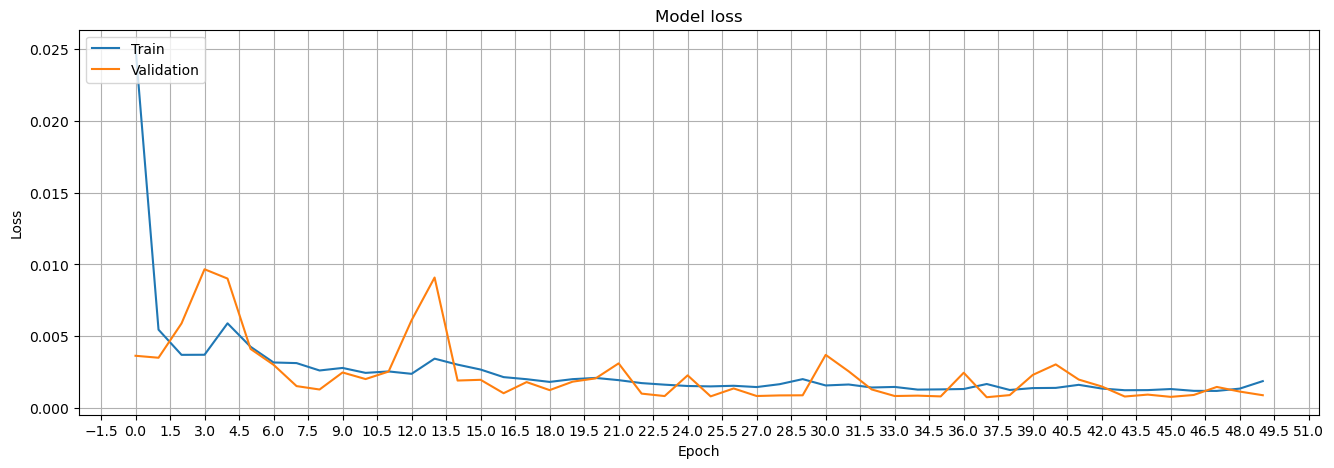

In [115]:
fig, ax = plt.subplots(figsize=(16, 5))

# Plot training loss
ax.plot(history.history["loss"], label="Train")

if 'val_loss' in history.history:
    ax.plot(history.history["val_loss"], label="Validation")

ax.set_title("Model loss")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(50))
ax.legend(loc="upper left")
ax.grid()
plt.show()

7/7 [==============================] - 1s 61ms/step


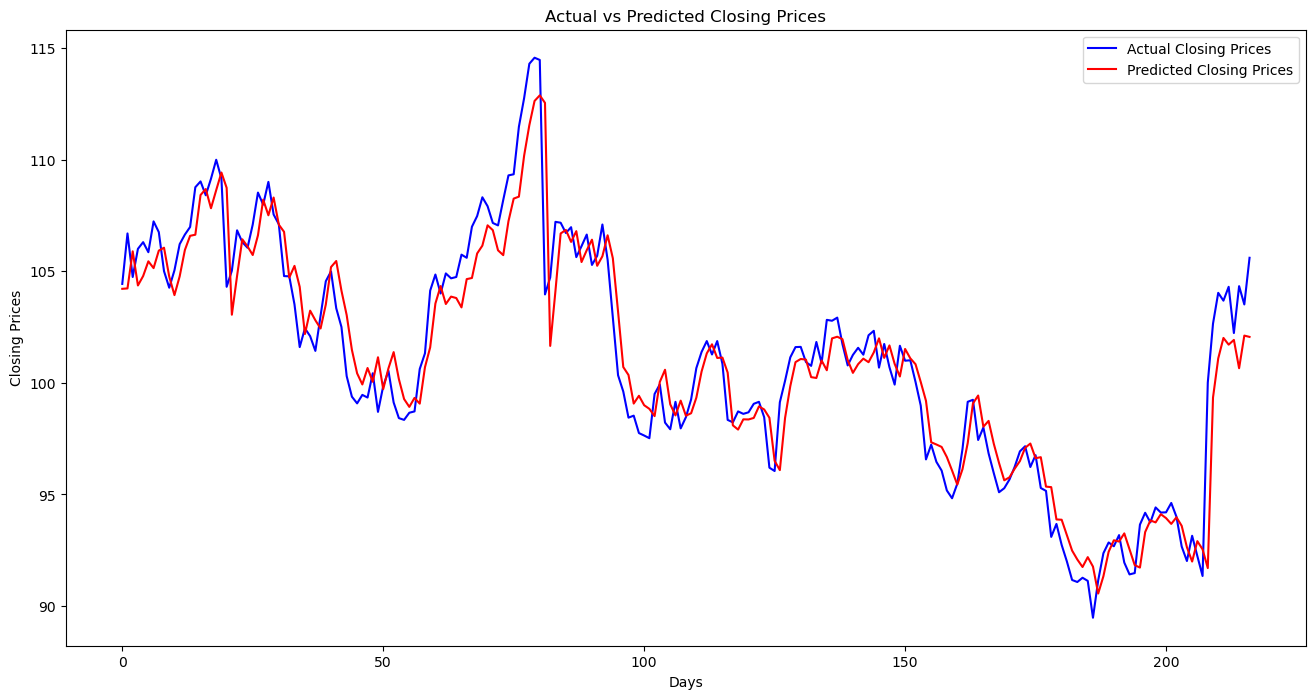

Median Absolute Error (MAE): 1.2
Mean Absolute Percentage Error (MAPE): 1.18 %
Median Absolute Percentage Error (MDAPE): 1.0 %


In [116]:
# Evaluate Model Performance

y_predicted_close = model.predict(x_test) # predict closing prices
y_predicted_close = scaler_target.inverse_transform(y_predicted_close) # unscale predictions
y_true_close= scaler_target.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(16, 8))
plt.plot(y_true_close, label='Actual Closing Prices', color='blue')
plt.plot(y_predicted_close, label='Predicted Closing Prices', color='red')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.legend()
plt.show()

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_true_close, y_predicted_close)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_true_close, y_predicted_close)/ y_true_close))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_true_close, y_predicted_close)/ y_true_close)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

# Model 2: With Sentiment

In [132]:
model2 = Sequential()
n_neurons2 = x_train2.shape[1] * x_train2.shape[2]
model2.add(LSTM(n_neurons2, return_sequences=True, input_shape=(x_train2.shape[1], x_train2.shape[2]))) 
model2.add(LSTM(n_neurons2, return_sequences=False))
model2.add(Dense(5)) # for 6 features besides close - best
model2.add(Dense(1))

# Compile the model
model2.compile(optimizer="adam", loss="mean_squared_error")

# Train Model
callback = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model2.fit(x_train2, y_train2, 
                    batch_size = 16, 
                    epochs = 50,
                    callbacks = [callback],
                    validation_data=(x_val2, y_val2)
                   )

Epoch 1/50
23/23 [==============================] - 5s 146ms/step - loss: 0.0248 - val_loss: 0.0062
Epoch 2/50
23/23 [==============================] - 3s 146ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 3/50
23/23 [==============================] - 3s 143ms/step - loss: 0.0037 - val_loss: 0.0046
Epoch 4/50
23/23 [==============================] - 3s 142ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 5/50
23/23 [==============================] - 4s 168ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 6/50
23/23 [==============================] - 3s 152ms/step - loss: 0.0028 - val_loss: 0.0041
Epoch 7/50
23/23 [==============================] - 4s 155ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 8/50
23/23 [==============================] - 4s 166ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 9/50
23/23 [==============================] - 3s 143ms/step - loss: 0.0028 - val_loss: 0.0113
Epoch 10/50
23/23 [==============================] - 4s 173ms/step - loss: 0.0031 - val_loss: 0.0028

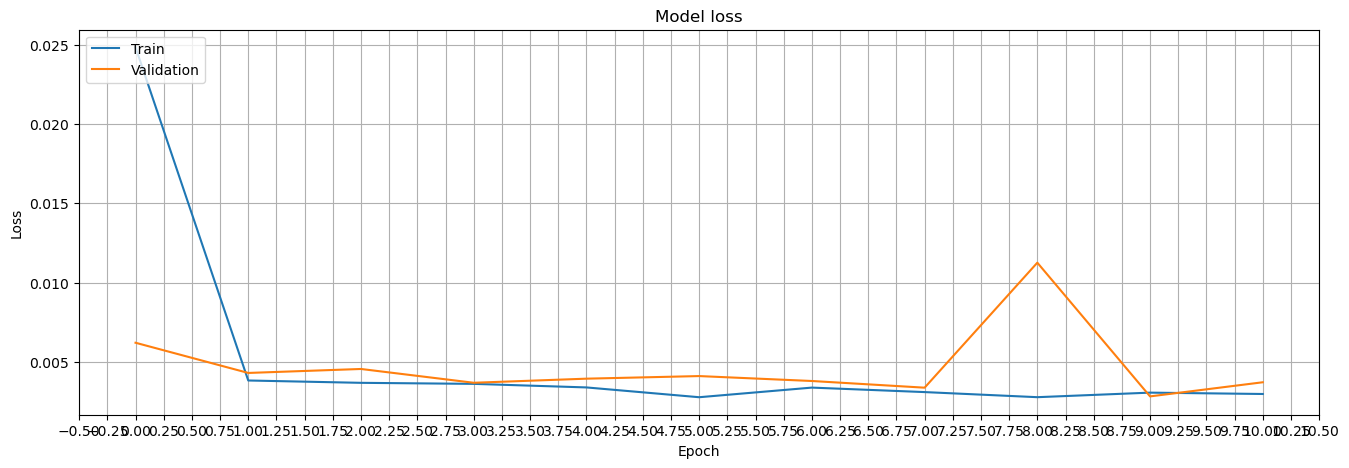

In [133]:
fig, ax = plt.subplots(figsize=(16, 5))

# Plot training loss
ax.plot(history.history["loss"], label="Train")

if 'val_loss' in history.history:
    ax.plot(history.history["val_loss"], label="Validation")

ax.set_title("Model loss")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(50))
ax.legend(loc="upper left")
ax.grid()
plt.show()

7/7 [==============================] - 1s 61ms/step


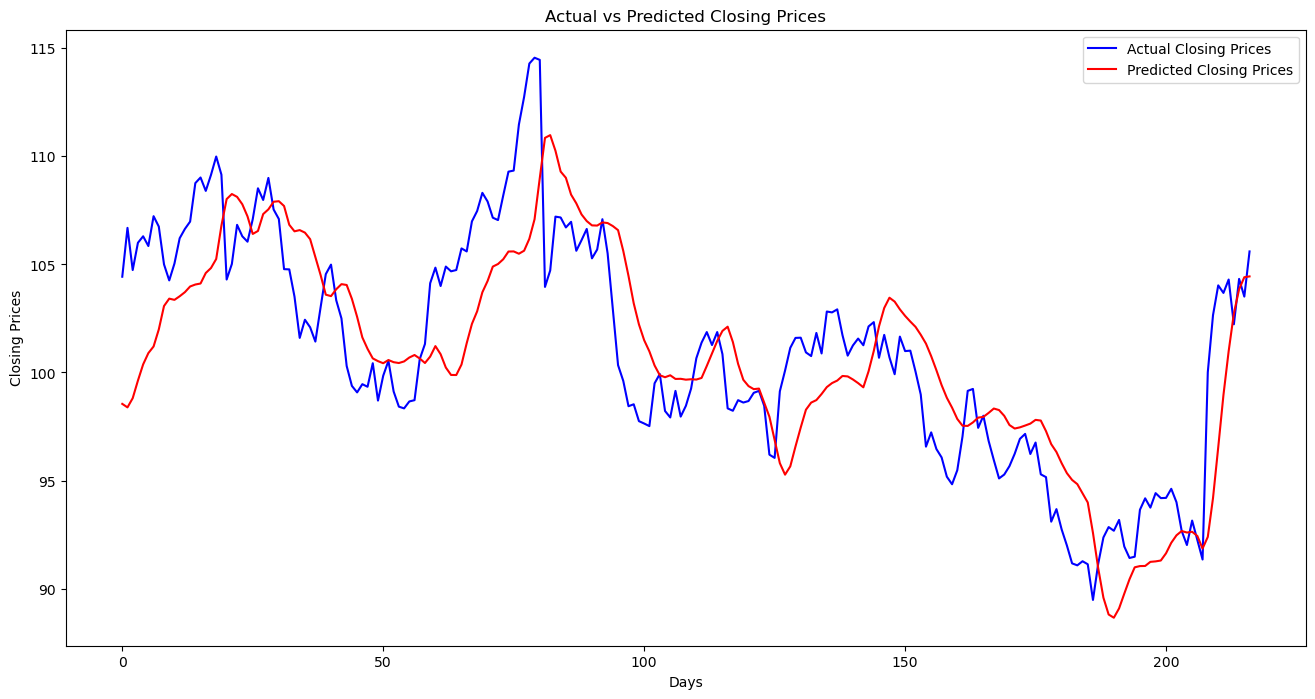

Median Absolute Error (MAE): 2.7
Mean Absolute Percentage Error (MAPE): 2.66 %
Median Absolute Percentage Error (MDAPE): 2.48 %


In [134]:
# Evaluate Model Performance

y_predicted_close2 = model2.predict(x_test2) # predict closing prices
y_predicted_close2 = scaler_target2.inverse_transform(y_predicted_close2) # unscale predictions
y_true_close2 = scaler_target2.inverse_transform(y_test2.reshape(-1, 1))

plt.figure(figsize=(16, 8))
plt.plot(y_true_close2, label='Actual Closing Prices', color='blue')
plt.plot(y_predicted_close2, label='Predicted Closing Prices', color='red')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.legend()
plt.show()

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_true_close2, y_predicted_close2)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_true_close2, y_predicted_close2)/ y_true_close2))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_true_close2, y_predicted_close2)/ y_true_close2)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')